# Choose Cluster

In [1]:
cluster_input = 1
cluster = str(cluster_input)

# Quick Links

<ol>
    <li><a href=#prep_sig_scores>Prepare Significance Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Confidence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from plotnine import *
sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
plt.style.use('default')

## Addresses

In [3]:
real_base = '/mnt/lab_data3/soumyak/adpd/'
real_effect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
real_noneffect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'

## Get Input Sequences

In [4]:
real_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_effect_fasta)) if i%2==1]
real_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_effect_seqs]

print('Num Real effect sequences:', '\t', '\t', len(real_effect_onehot))

real_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_noneffect_fasta)) if i%2==1]
real_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_noneffect_seqs]

print('Num Real noneffect sequences:', '\t', '\t', len(real_noneffect_onehot))

Num Real effect sequences: 	 	 642
Num Real noneffect sequences: 	 	 642


# Prepare Real Scores <a name='prep_sig_scores' />

In [5]:
merged_real_effect_scores = np.zeros(shape=(len(real_effect_seqs), 1000, 4))
merged_real_noneffect_scores = np.zeros(shape=(len(real_noneffect_seqs), 1000, 4))
merged_real_explain_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_effect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    real_effect_scores = get_hyp_scores(real_effect_file, real_effect_seqs)
    real_effect_scores = np.array(real_effect_scores)
    merged_real_effect_scores = merged_real_effect_scores + real_effect_scores
    
    real_noneffect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    real_noneffect_scores = get_hyp_scores(real_noneffect_file, real_noneffect_seqs)
    real_noneffect_scores = np.array(real_noneffect_scores)
    merged_real_noneffect_scores = merged_real_noneffect_scores + real_noneffect_scores
       
    real_explain_scores = []
    
    for i,j in enumerate(real_effect_scores): # iterate over sequences
        real_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                real_effect_scores[i][475:525]]))
        real_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    real_noneffect_scores[i][475:525]]))
        real_explain_score_seq = real_50bp_imp_effect - real_50bp_imp_noneffect
        real_explain_scores.append(real_explain_score_seq)
    
    merged_real_explain_scores = merged_real_explain_scores + np.array(real_explain_scores)
    
merged_real_effect_scores = merged_real_effect_scores / (fold + 1)
merged_real_noneffect_scores = merged_real_noneffect_scores / (fold + 1)
merged_real_explain_scores = merged_real_explain_scores / (fold + 1)

print('Num Real GkmExplain scores:', '\t', '\t', len(merged_real_explain_scores))
print('Num Real Effect scores:', '\t', '\t', len(merged_real_effect_scores))
print('Num Real Non-Effect scores:', '\t', '\t', len(merged_real_noneffect_scores))

#--------------------------------------------------------#

merged_real_ism_scores = np.zeros(shape=(len(real_effect_seqs),))
merged_real_delta_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    real_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    merged_real_ism_scores = merged_real_ism_scores + real_ism_scores
    merged_real_delta_scores = merged_real_delta_scores + real_delta_scores
        
merged_real_ism_scores = merged_real_ism_scores / (fold + 1)
merged_real_delta_scores = merged_real_delta_scores / (fold + 1)

print('Num Real ISM scores:', '\t', '\t', '\t', len(merged_real_ism_scores))
print('Num Real deltaSVM scores:', '\t', '\t', len(merged_real_delta_scores))

Num Real GkmExplain scores: 	 	 642
Num Real Effect scores: 	 	 642
Num Real Non-Effect scores: 	 	 642
Num Real ISM scores: 	 	 	 642
Num Real deltaSVM scores: 	 	 642


# Prepare Null Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 12100000
Num Null GkmExplain scores: 	 60500
Num Null ISM scores: 	 	 60500
Num Null deltaSVM scores: 	 60500


# Get Real Confidence Scores <a name='prep_conf_scores' />

In [7]:
real_confidence_dict = {'real_center_start': [], 'real_center_end': [],
                        'real_center_effect': [], 'real_center_noneffect': [],
                        'real_bg_effect': [], 'real_bg_noneffect': [],
                        'real_magnitude_score': [], 'real_prominence_score': [],
                        'real_active_allele': [], 'real_inactive_allele': [],
                        'real_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(real_effect_seqs)):
    real_per_seq_dict = {'real_scores_active': [], 'real_scores_inactive': [],
                         'real_scores_effect': [], 'real_scores_noneffect': [],
                         'real_active_allele': ''}
    real_center_start = 0
    real_center_end = 0
    real_center_effect = 0
    real_center_noneffect = 0
    real_bg_effect = 0
    real_bg_noneffect = 0
    
    real_effect_total = np.sum(np.array([np.sum(i) for i in merged_real_effect_scores[seq][400:600]]))
    real_noneffect_total = np.sum(np.array([np.sum(i) for i in merged_real_noneffect_scores[seq][400:600]]))
    real_per_seq_dict['real_scores_effect'] = [np.sum(j) for j in merged_real_effect_scores[seq]]
    real_per_seq_dict['real_scores_noneffect'] = [np.sum(j) for j in merged_real_noneffect_scores[seq]]
    if real_effect_total >= real_noneffect_total:
        real_per_seq_dict['real_active_allele'] = 'effect'
        real_per_seq_dict['real_inactive_allele'] = 'noneffect'
        real_confidence_dict['real_active_allele'].append('effect')
        real_confidence_dict['real_inactive_allele'].append('noneffect')
    else:
        real_per_seq_dict['real_active_allele'] = 'noneffect'
        real_per_seq_dict['real_inactive_allele'] = 'effect'
        real_confidence_dict['real_active_allele'].append('noneffect')
        real_confidence_dict['real_inactive_allele'].append('effect')
    real_per_seq_dict['real_scores_active'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_active_allele']]
    real_per_seq_dict['real_scores_inactive'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_inactive_allele']]
    
    start = 499
    end = 499
    while True:
        if real_per_seq_dict['real_scores_active'][start - 1] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if real_per_seq_dict['real_scores_active'][end] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        real_motif_len = end - start
        if (real_motif_len) < 7:
            real_center_start = start - math.floor((10 - real_motif_len) / 2)
            real_center_end = end + math.ceil((10 - real_motif_len) / 2)
        else:
            real_center_start = start
            real_center_end = end
    else:
        real_center_start = start - 4
        real_center_end = end + 6
    
    real_confidence_dict['real_center_start'].append(real_center_start)
    real_confidence_dict['real_center_end'].append(real_center_end)
    real_confidence_dict['real_center_len'].append(real_center_end - real_center_start)
    
    for i,j in enumerate(real_per_seq_dict['real_scores_active'][real_center_start:real_center_end]):
        if real_per_seq_dict['real_scores_effect'][i+real_center_start] >= 0:
            real_center_effect += real_per_seq_dict['real_scores_effect'][i+real_center_start]
        if real_per_seq_dict['real_scores_noneffect'][i+real_center_start] >= 0:
            real_center_noneffect += real_per_seq_dict['real_scores_noneffect'][i+real_center_start]
        assert j == real_per_seq_dict['real_scores_active'][i+real_center_start]
    for i,j in enumerate(real_per_seq_dict['real_scores_active']):
        if real_per_seq_dict['real_scores_effect'][i] >= 0:
            real_bg_effect += real_per_seq_dict['real_scores_effect'][i]
        if real_per_seq_dict['real_scores_noneffect'][i] >= 0:
            real_bg_noneffect += real_per_seq_dict['real_scores_noneffect'][i]
        assert j == real_per_seq_dict['real_scores_active'][i]
    
    real_magnitude_score = real_center_effect - real_center_noneffect
    real_prominence_score = (real_center_effect / real_bg_effect) - (real_center_noneffect / real_bg_noneffect)
    
    real_confidence_dict['real_center_effect'].append(real_center_effect)
    real_confidence_dict['real_center_noneffect'].append(real_center_noneffect)
    real_confidence_dict['real_bg_effect'].append(real_bg_effect)
    real_confidence_dict['real_bg_noneffect'].append(real_bg_noneffect)
    real_confidence_dict['real_magnitude_score'].append(real_magnitude_score)
    real_confidence_dict['real_prominence_score'].append(real_prominence_score)

print('Mean Real motif length:', '\t', '\t', statistics.mean(real_confidence_dict['real_center_len']))
print('Median Real motif length:', '\t', '\t', statistics.median(real_confidence_dict['real_center_len']))
print('St. Dev Real motif length:', '\t', '\t', statistics.stdev(real_confidence_dict['real_center_len']))
print('Mode Real motif length:', '\t', '\t', statistics.mode(real_confidence_dict['real_center_len']))
print('Max Real motif length:', '\t', '\t', '\t', max(real_confidence_dict['real_center_len']))
print('Min Real motif lenght:', '\t', '\t', '\t', min(real_confidence_dict['real_center_len']))

Per-base Importance Score Threshold:  	 0.03122790499999989
Mean Real motif length: 	 	 10.87538940809969
Median Real motif length: 	 	 10.0
St. Dev Real motif length: 	 	 3.0793031488384086
Mode Real motif length: 	 	 10
Max Real motif length: 	 	 	 37
Min Real motif lenght: 	 	 	 7


# Get Null Confidence Scores

In [8]:
null_confidence_dict = {'null_center_start': [], 'null_center_end': [],
                        'null_center_effect': [], 'null_center_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_center_start = 0
    null_center_end = 0
    null_center_effect = 0
    null_center_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum(merged_null_effect_scores[seq])
    null_noneffect_total = sum(merged_null_noneffect_scores[seq])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total >= null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 99
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        null_motif_len = end - start
        if (null_motif_len) < 7:
            null_center_start = start - math.floor((10 - null_motif_len) / 2)
            null_center_end = end + math.ceil((10 - null_motif_len) / 2)
        else:
            null_center_start = start
            null_center_end = end
    else:
        null_center_start = start - 4
        null_center_end = end + 6
    
    null_confidence_dict['null_center_start'].append(null_center_start)
    null_confidence_dict['null_center_end'].append(null_center_end)
    null_confidence_dict['null_center_len'].append(null_center_end - null_center_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_center_start:null_center_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_center_start] >= 0:
            null_center_effect += null_per_seq_dict['null_scores_effect'][i+null_center_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_center_start] >= 0:
            null_center_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_center_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_center_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_center_effect - null_center_noneffect
    null_prominence_score = (null_center_effect / null_bg_effect) - (null_center_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_center_effect'].append(null_center_effect)
    null_confidence_dict['null_center_noneffect'].append(null_center_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null motif length:', '\t', '\t', statistics.mean(null_confidence_dict['null_center_len']))
print('Median Null motif length:', '\t', '\t', statistics.median(null_confidence_dict['null_center_len']))
print('St. Dev Null motif length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_center_len']))
print('Mode Null motif length:', '\t', '\t', statistics.mode(null_confidence_dict['null_center_len']))
print('Max Null motif length:', '\t', '\t', '\t', max(null_confidence_dict['null_center_len']))
print('Min Null motif lenght:', '\t', '\t', '\t', min(null_confidence_dict['null_center_len']))

Per-base Importance Score Threshold:  	 0.03122790499999989
Mean Null motif length: 	 	 10.796644628099173
Median Null motif length: 	 	 10.0
St. Dev Null motif length: 	 	 3.0341971727036396
Mode Null motif length: 	 	 10
Max Null motif length: 	 	 	 48
Min Null motif lenght: 	 	 	 7


# Make Real Scores DataFrame <a name='prep_score_df' />

In [9]:
snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')

snp_scores['gc'] = [((real_noneffect_seqs[index].count('G') + real_noneffect_seqs[index].count('C'))
                     / len(real_noneffect_seqs[index])) for index in range(len(real_noneffect_seqs))]
snp_scores['explain_score'] = merged_real_explain_scores
snp_scores['ism_score'] = merged_real_ism_scores
snp_scores['delta_score'] = merged_real_delta_scores
snp_scores['magnitude_score'] = real_confidence_dict['real_magnitude_score']
snp_scores['prominence_score'] = real_confidence_dict['real_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_motif = []
inactive_motif = []
diff_motif = []

for index,row in snp_scores.iterrows():
    best_gwas = ''
    lowest_pval = 1
    has_coloc = False
    locus = 0
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] < lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    gwas.append(best_gwas)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)
    locus_num.append(locus)
    if real_confidence_dict['real_active_allele'][index] == 'effect':
        active_seq = real_effect_seqs[index]
        inactive_seq = real_noneffect_seqs[index]
    else:
        active_seq = real_noneffect_seqs[index]
        inactive_seq = real_effect_seqs[index]
    center_start = real_confidence_dict['real_center_start'][index]
    center_end = real_confidence_dict['real_center_end'][index]
    active_motif.append(active_seq[center_start:center_end])
    inactive_motif.append(inactive_seq[center_start:center_end])
    diff_motif.append(active_seq[center_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:center_end])

snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['locus_num'] = locus_num
snp_scores['active_motif'] = active_motif
snp_scores['inactive_motif'] = inactive_motif
snp_scores['diff_motif'] = diff_motif
snp_scores['active_allele'] = real_confidence_dict['real_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)

print('Real Scores:')
print()
display(snp_scores.head())
display(snp_scores.shape)

Real Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele
0,chr1,39883755,39883756,rs61781270,A,G,G,"A,C",G,"A,C",+,31,0.560,-0.120434,-0.190862,-1.121088,-0.047988,-0.026694,6,Alzheimers_Kunkle_2019,7.110000e-06,True,CCGCCTT,CCACCTT,CC(G/A)CCTT,noneffect
1,chr1,154865462,154865463,rs116839452,G,A,A,G,A,G,+,10,0.521,0.486904,0.763757,4.403273,0.264595,0.113948,5,Nalls_23andMe,1.607560e-01,False,GCATAGTAAT,GCATAATAAT,GCATA(G/A)TAAT,effect
2,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,0.031890,0.049888,0.266571,0.015386,0.004970,8,23andme_PD_hg38,1.640000e-14,False,ACCAGGGTAC,ACCAAGGTAC,ACCA(G/A)GGTAC,effect
3,chr1,161185601,161185602,rs4575098,A,G,G,A,G,A,+,129,0.433,-0.598793,-0.931719,-5.352862,0.000000,0.000000,1,Alzheimers_Jansen_2018,2.050000e-10,True,AAATGTTAAT,AAATATTAAT,AAAT(G/A)TTAAT,noneffect
4,chr1,171741264,171741265,rs2298914,T,C,C,T,C,T,-,14,0.438,-0.007824,-0.012797,-0.051008,-0.028155,-0.010600,2,Nalls_23andMe,6.215975e-02,False,GGCTCTCCTT,GGCTTTCCTT,GGCT(C/T)TCCTT,noneffect


(642, 26)

# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = real_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
display(null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs61781270,-0.106112,-0.157970,-0.882770,-0.029558,-0.016100,0.560,6
1,rs116839452,-0.001206,-0.001667,-0.033473,0.015997,0.011615,0.521,5
2,rs12726330,0.203562,0.303735,1.732930,0.060004,0.028934,0.628,8
3,rs4575098,-0.034844,-0.051670,-0.312090,-0.000159,-0.000091,0.433,1
4,rs2298914,-0.262013,-0.390450,-2.256130,-0.085030,-0.045270,0.438,2


(60500, 8)

## Get Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.537901
null_ism_score          -0.801715
null_delta_score        -4.637212
null_magnitude_score    -0.318598
null_prominence_score   -0.150643
gc                       0.345000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.530615
null_ism_score           0.790682
null_delta_score         4.552743
null_magnitude_score     0.300374
null_prominence_score    0.147283
gc                       0.717000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.3150
0.1    0.3940
0.2    0.4378
0.3    0.4730
0.4    0.4976
0.5    0.5150
0.6    0.5450
0.7    0.5780
0.8    0.6110
0.9    0.6560
1.0    0.7840
Name: gc, dtype: float64

## Test if Scores are Distributed identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.015655,1.0,0.000953,1.0
1,1.000000,1.000000,1.0,1.0,0.000021,1.0,1.000000,1.0,1.000000,1.0
2,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
3,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,1.000000,0.000021,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
5,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
6,0.015655,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.009866,1.0
7,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
8,0.000953,1.000000,1.0,1.0,1.000000,1.0,0.009866,1.0,1.000000,1.0
9,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


Significant Differences:  3

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.014794,1.0,0.000953,1.0
1,1.000000,1.000000,1.0,1.0,0.000016,1.0,1.000000,1.0,1.000000,1.0
2,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
3,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,1.000000,0.000016,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
5,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
6,0.014794,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.009299,1.0
7,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
8,0.000953,1.000000,1.0,1.0,1.000000,1.0,0.009299,1.0,1.000000,1.0
9,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


Significant Differences:  3

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.018515,1.0,0.000619,1.0
1,1.000000,1.000000,1.0,1.0,0.000023,1.0,1.000000,1.0,1.000000,1.0
2,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
3,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,1.000000,0.000023,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
5,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
6,0.018515,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.013976,1.0
7,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
8,0.000619,1.000000,1.0,1.0,1.000000,1.0,0.013976,1.0,1.000000,1.0
9,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


Significant Differences:  2

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,3.771971e-11,1.0,2.862368e-07,1.0
1,1.000000e+00,1.000000,1.0,1.0,0.001197,1.0,1.000000e+00,1.0,1.000000e+00,1.0
2,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0
3,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0
4,1.000000e+00,0.001197,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0
5,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0
6,3.771971e-11,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,8.422034e-02,1.0
7,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0
8,2.862368e-07,1.000000,1.0,1.0,1.000000,1.0,8.422034e-02,1.0,1.000000e+00,1.0
9,1.000000e+00,1.000000,1.0,1.0,1.000000,1.0,1.000000e+00,1.0,1.000000e+00,1.0


Significant Differences:  3

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.000461,1.0,0.001903,1.0
1,1.000000,1.000000,1.0,1.0,0.009587,1.0,1.000000,1.0,1.000000,1.0
2,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
3,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,1.000000,0.009587,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
5,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
6,0.000461,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,0.070003,1.0
7,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
8,0.001903,1.000000,1.0,1.0,1.000000,1.0,0.070003,1.0,1.000000,1.0
9,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


Significant Differences:  3


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

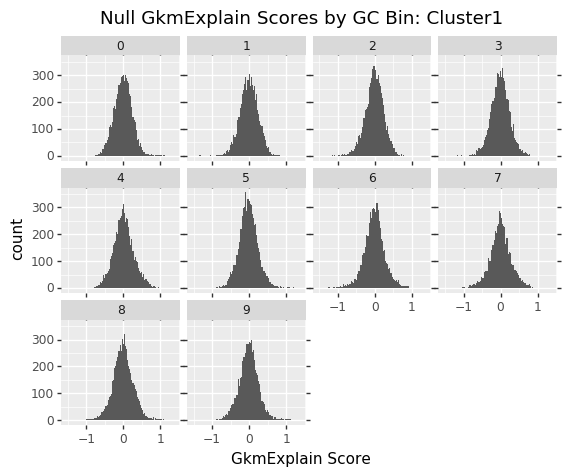

<ggplot: (8763665619909)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.004723586563405158
Stdev: 	 0.23218507152790452

KstestResult(statistic=0.003410230658256186, pvalue=0.4824806388642394)



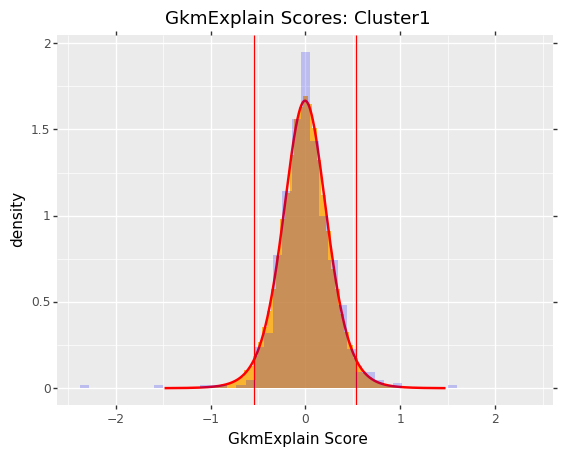

<ggplot: (-9223363273449744033)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

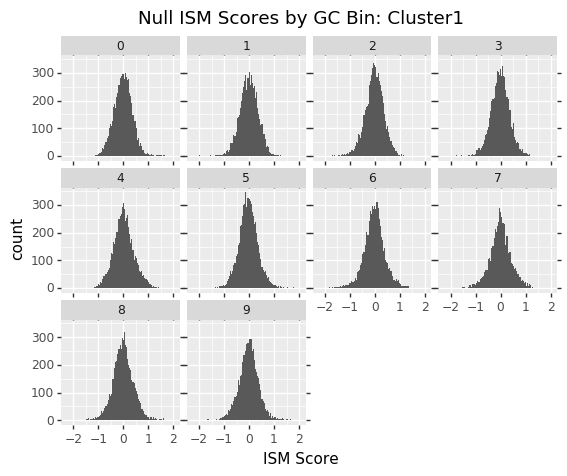

<ggplot: (8763405024022)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.006976121118005213
Stdev: 	 0.3457912809235969

KstestResult(statistic=0.0035146705479039975, pvalue=0.4435700739744785)



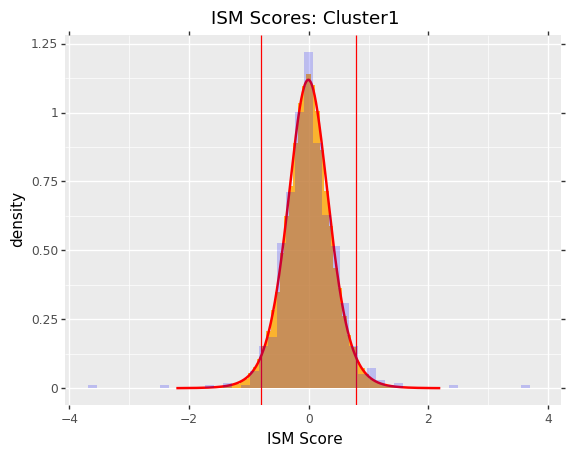

<ggplot: (-9223363273450186282)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

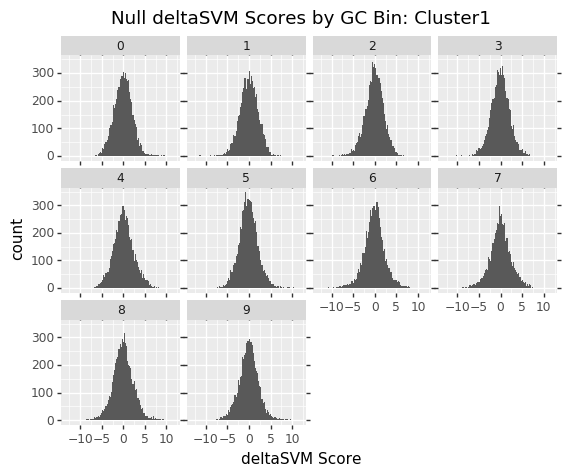

<ggplot: (8763405088071)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.04069233448156688
Stdev: 	 1.997819159668656

KstestResult(statistic=0.0033090593134230684, pvalue=0.5216680902878523)



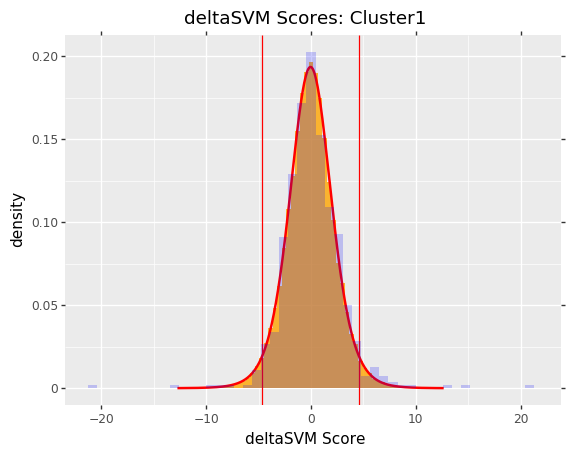

<ggplot: (8763404083769)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

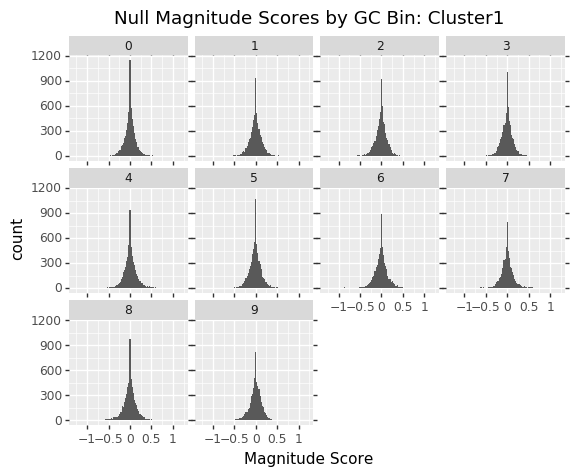

<ggplot: (8763404162203)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.0030049510847572937
Stdev: 	 0.09591376532785478

KstestResult(statistic=0.03251529021130123, pvalue=5.536577818979688e-56)



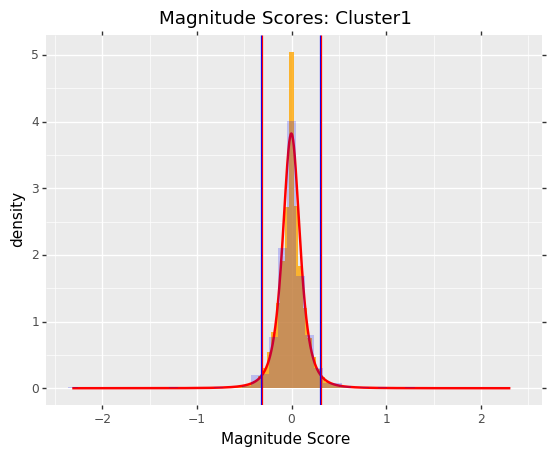

<ggplot: (8763403685531)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

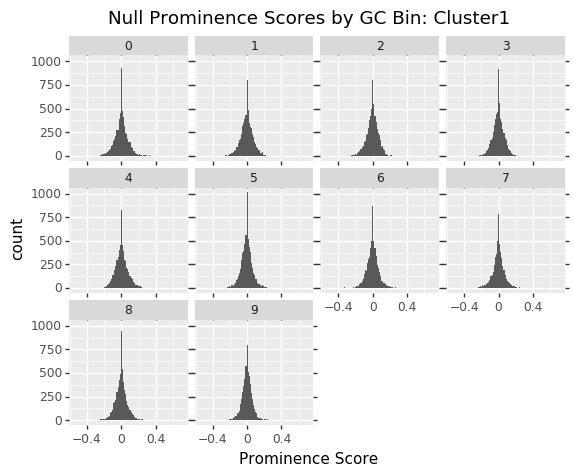

<ggplot: (-9223363273451100819)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0016491892700802645
Stdev: 	 0.05179601942615249

KstestResult(statistic=0.028959656956413504, pvalue=1.6969318346352024e-44)



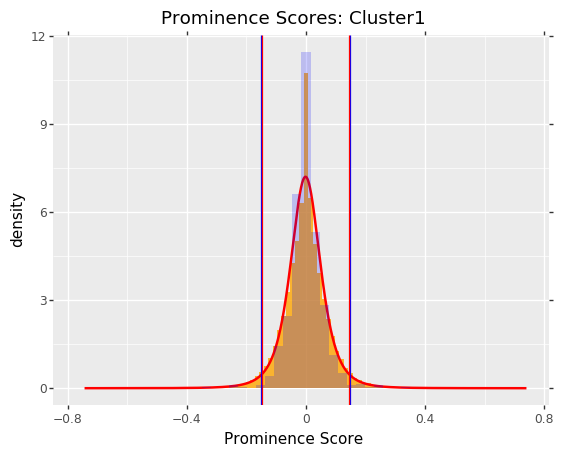

<ggplot: (8763403623011)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.00434458916946283
Stdev: 	 0.011572789171185668

KstestResult(statistic=0.015755094768262923, pvalue=4.98037382451179e-216)



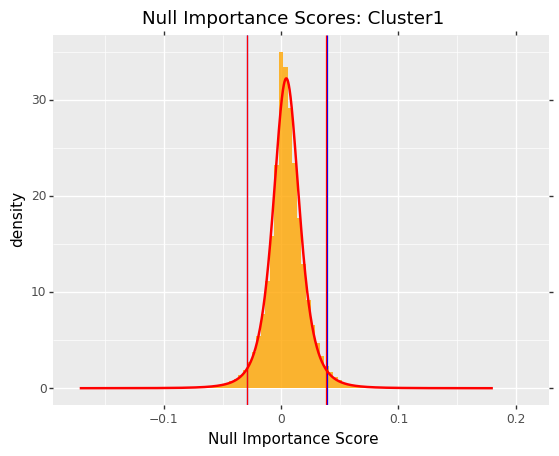

<ggplot: (8763404574703)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values

sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps.effect.replace('NAN', 'ZYX321', inplace=True)
sig_snps.noneffect.replace('NAN', 'ZYX321', inplace=True)
unique_sig_snps = sig_snps.sort_values(by=['rsid', 'effect'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
sig_snps.effect.replace('ZYX321', 'NAN', inplace=True)
sig_snps.noneffect.replace('ZYX321', 'NAN', inplace=True)
unique_sig_snps.effect.replace('ZYX321', 'NAN', inplace=True)
unique_sig_snps.noneffect.replace('ZYX321', 'NAN', inplace=True)
unique_sig_snps.sort_values(by=['confidence', 'prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)

print('Unique Significant SNPs:')
print()
display(unique_sig_snps)
display(unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores))
print('Unique SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
59,chr11,86103987,86103988,rs1237999,A,G,G,A,A,G,+,16,0.339,-1.504711,-2.344655,-13.414169,-1.265835,-0.337146,0,Alzheimers_Jansen_2018,7.140000e-16,False,TATGAGTCACCA,TATAAGTCACCA,TAT(G/A)AGTCACCA,noneffect,0.000182,0.000134,0.000139,0.000033,0.001455,2
270,chr17,45959712,45959713,rs113793114,G,A,G,A,G,A,+,54,0.411,0.691103,1.092992,6.309519,0.428187,0.254223,1,23andme_PD_hg38,2.580000e-22,True,AGGAGGCGGA,AGGAGGCAGA,AGGAGGC(G/A)GA,effect,0.016824,0.012727,0.012668,0.017058,0.005950,2
583,chr4,89837895,89837896,rs2619363,NAN,NAN,G,"C,T",G,"C,T",.,103,0.527,-0.925406,-1.414831,-8.427124,-0.740692,-0.249215,5,23andme_PD_hg38,1.430000e-08,True,CCAATCAGCGCCTGCCAG,CCAATCAGCCCCTGCCAG,CCAATCAGC(G/C)CCTGCCAG,noneffect,0.004007,0.003465,0.002865,0.003372,0.006512,2
41,chr11,60251676,60251677,rs636317,C,T,C,T,T,C,-,11,0.406,2.374887,3.694154,21.288201,2.357696,0.227957,1,Alzheimers_Kunkle_2019,5.910000e-15,False,TTTGCTGCCATCTGCTGGGAAATTGTG,TTTGCTGCTATCTGCTGGGAAATTGTG,TTTGCTGC(C/T)ATCTGCTGGGAAATTGTG,effect,0.000006,0.000005,0.000004,0.000000,0.009785,2
240,chr17,45896863,45896864,rs62056782,T,C,C,T,C,T,-,54,0.622,0.968207,1.511886,8.711674,0.934118,0.219841,8,23andme_PD_hg38,3.940000e-22,True,CGCCCTCTTGTG,CGCCCTCCTGTG,CGCCCTC(T/C)TGTG,effect,0.002924,0.002228,0.002227,0.001091,0.011174,2
222,chr17,45852666,45852667,rs62054825,G,A,G,A,G,A,+,54,0.482,0.806529,1.262465,7.246744,0.784210,0.178299,3,23andme_PD_hg38,1.250000e-22,True,GCTCCCGGAAGTGGAGTCATCCT,GCTCCCAGAAGTGGAGTCATCCT,GCTCCC(G/A)GAAGTGGAGTCATCCT,effect,0.007936,0.006137,0.006280,0.001884,0.026975,2
430,chr2,95324017,95324018,rs3772034,G,A,G,A,A,G,-,85,0.609,0.554599,0.879180,4.995048,0.557009,0.175432,7,Nalls_23andMe,8.120010e-03,False,CAGAGGGAGCCCG,CAGAGGAAGCCCG,CAGAGG(G/A)AGCCCG,effect,0.042079,0.033105,0.035185,0.006545,0.028463,2
294,chr17,46038519,46038520,rs12150090,T,C,C,"G,T",C,"G,T",-,54,0.489,0.836860,1.307331,7.565130,0.524768,0.163569,3,23andme_PD_hg38,2.510000e-22,True,CCAATCCCACA,CCAACCCCACA,CCAA(T/C)CCCACA,effect,0.006547,0.005086,0.004981,0.008132,0.035901,2
459,chr2,134719288,134719289,rs62171396,T,C,C,T,C,T,-,78,0.704,0.619902,0.991544,5.740914,0.476032,0.148838,9,Nalls_23andMe,1.039870e-02,False,CGGCTCTGGCAGAG,CGGCCCTGGCAGAG,CGGC(T/C)CTGGCAGAG,effect,0.027072,0.019955,0.019626,0.011835,0.048165,2
418,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,0.543,-1.053658,-1.675440,-9.611985,-0.310145,-0.149007,5,Alzheimers_Jansen_2018,1.220000e-04,True,CGCCTCC,CCCCTCC,C(G/C)CCTCC,noneffect,0.001873,0.001258,0.001291,0.054215,0.052132,1


(24, 32)


SNPs with Significant Scores: 	 	 	 24
Significant SNPs with Low Confidence: 	 	 8
Significant SNPs with Moderate Confidence: 	 7
Significant SNPs with High Confidence: 	 	 9

Total SNPs Tested:  	 	 	 	 642
Unique SNPs Tested:  	 	 	 	 567


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 59

RSID: rs1237999 	 	 || 	 chr11 : 86103987 - 86103988 	 || 	 Locus: 16

GWAS: Alzheimers_Jansen_2018 	 || 	 P-Value: 7.1400E-16 	 	 || 	 Coloc: False

Prominence P-Value: 1.4545E-03 	 || 	 Magnitude P-Value: 3.3058E-05 	 || 	 Confidence: 2

GkmExplain P-Value: 1.8214E-04 	 || 	 ISM P-Value: 1.3388E-04 	 || 	 deltaSVM P-Value: 1.3923E-04

----------------------------------------------------------------------------------------------------

Non-Effect Allele: G 	 	 || 	 Active Motif: TATGAGTCACCA



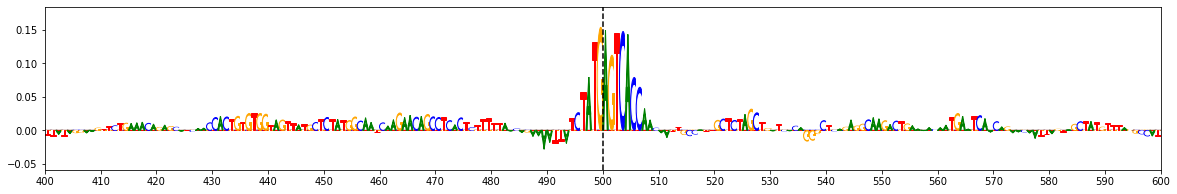


Effect Allele: A 	 	 || 	 Inactive Motif: TATAAGTCACCA



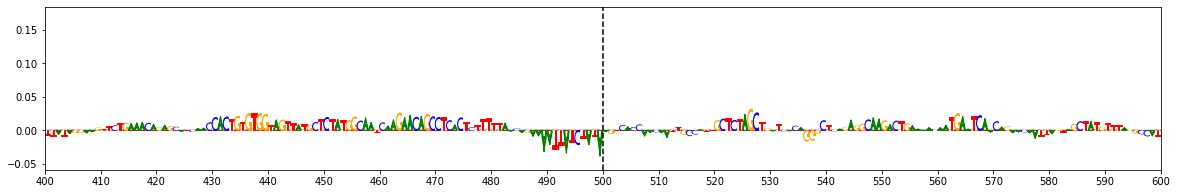


Difference Motif: TAT(G/A)AGTCACCA



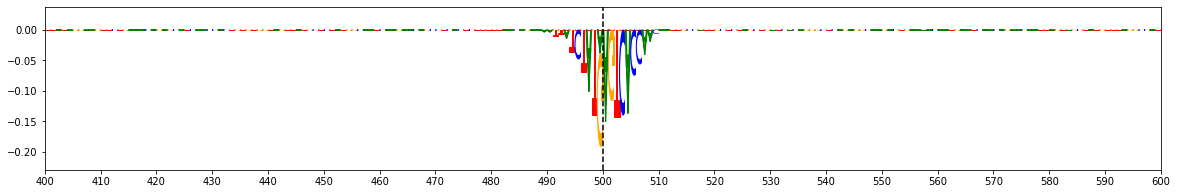


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 270

RSID: rs113793114 	 	 || 	 chr17 : 45959712 - 45959713 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 2.5800E-22 	 	 || 	 Coloc: True

Prominence P-Value: 5.9504E-03 	 || 	 Magnitude P-Value: 1.7058E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 1.6824E-02 	 || 	 ISM P-Value: 1.2727E-02 	 || 	 deltaSVM P-Value: 1.2668E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Motif: AGGAGGCGGA



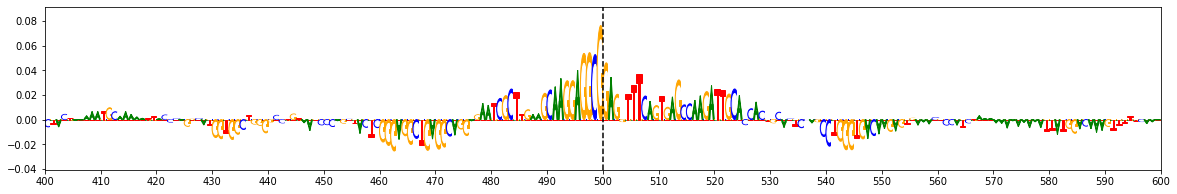


Non-Effect Allele: A 	 	 || 	 Inactive Motif: AGGAGGCAGA



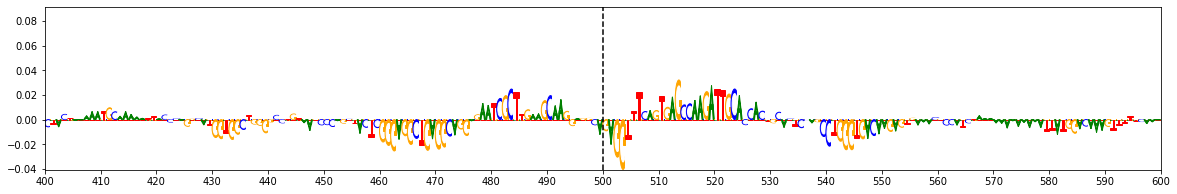


Difference Motif: AGGAGGC(G/A)GA



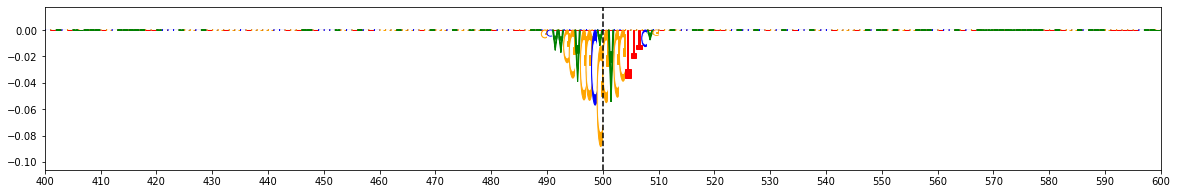


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 583

RSID: rs2619363 	 	 || 	 chr4 : 89837895 - 89837896 	 || 	 Locus: 103

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 1.4300E-08 	 	 || 	 Coloc: True

Prominence P-Value: 6.5124E-03 	 || 	 Magnitude P-Value: 3.3719E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 4.0071E-03 	 || 	 ISM P-Value: 3.4649E-03 	 || 	 deltaSVM P-Value: 2.8647E-03

----------------------------------------------------------------------------------------------------

Major Allele: G 	 	 || 	 Active Motif: CCAATCAGCGCCTGCCAG



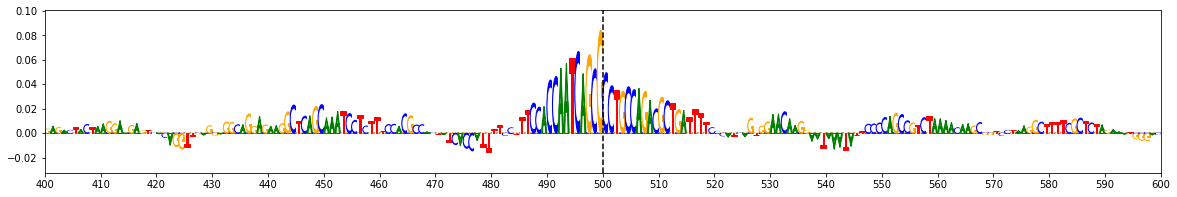


Minor Allele: C,T 	 	 || 	 Inactive Motif: CCAATCAGCCCCTGCCAG



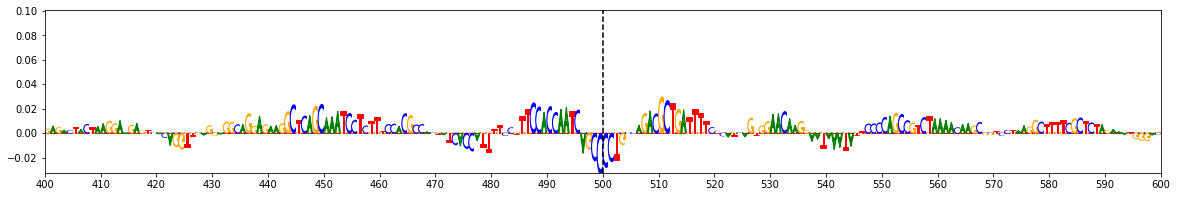


Difference Motif: CCAATCAGC(G/C)CCTGCCAG



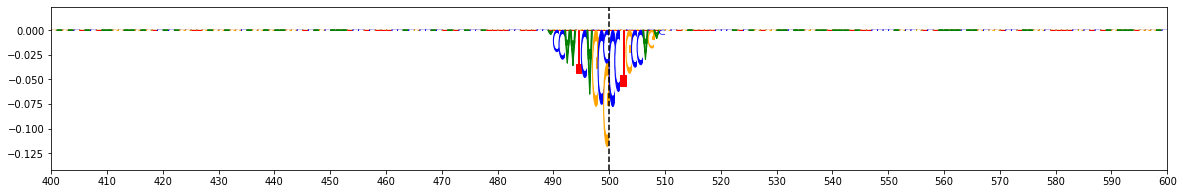


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 41

RSID: rs636317 	 	 || 	 chr11 : 60251676 - 60251677 	 || 	 Locus: 11

GWAS: Alzheimers_Kunkle_2019 	 || 	 P-Value: 5.9100E-15 	 	 || 	 Coloc: False

Prominence P-Value: 9.7851E-03 	 || 	 Magnitude P-Value: 0.0000E+00 	 || 	 Confidence: 2

GkmExplain P-Value: 6.2335E-06 	 || 	 ISM P-Value: 4.5444E-06 	 || 	 deltaSVM P-Value: 4.4077E-06

----------------------------------------------------------------------------------------------------

Effect Allele: C 	 	 || 	 Active Motif: TTTGCTGCCATCTGCTGGGAAATTGTG



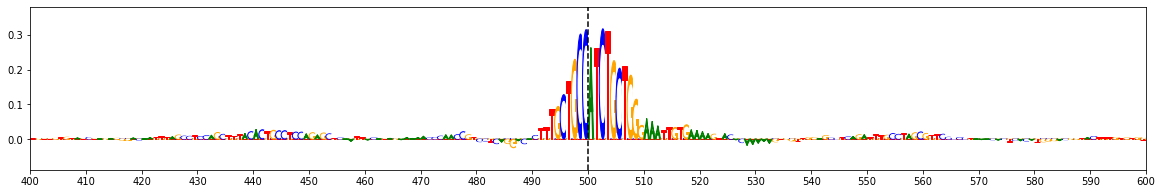


Non-Effect Allele: T 	 	 || 	 Inactive Motif: TTTGCTGCTATCTGCTGGGAAATTGTG



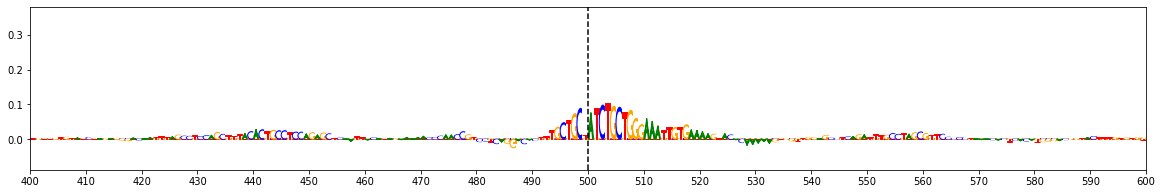


Difference Motif: TTTGCTGC(C/T)ATCTGCTGGGAAATTGTG



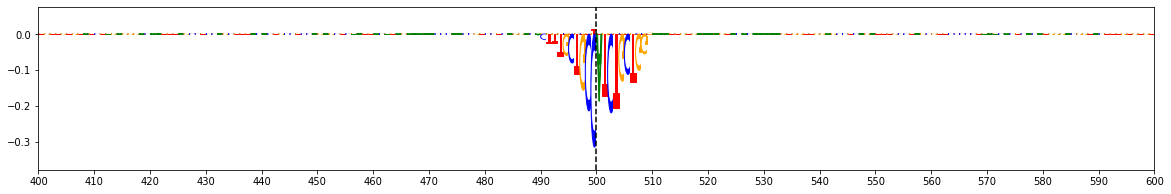


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 240

RSID: rs62056782 	 	 || 	 chr17 : 45896863 - 45896864 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 3.9400E-22 	 	 || 	 Coloc: True

Prominence P-Value: 1.1174E-02 	 || 	 Magnitude P-Value: 1.0909E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 2.9239E-03 	 || 	 ISM P-Value: 2.2277E-03 	 || 	 deltaSVM P-Value: 2.2274E-03

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Motif: CGCCCTCTTGTG



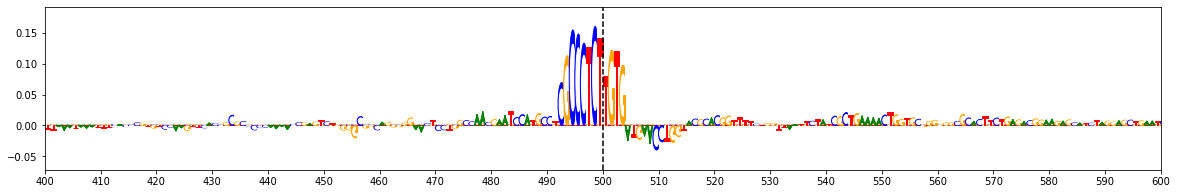


Non-Effect Allele: C 	 	 || 	 Inactive Motif: CGCCCTCCTGTG



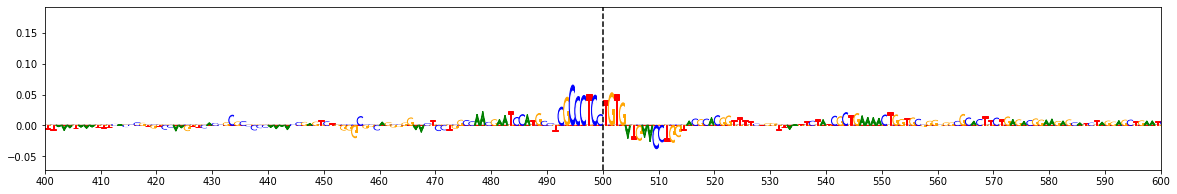


Difference Motif: CGCCCTC(T/C)TGTG



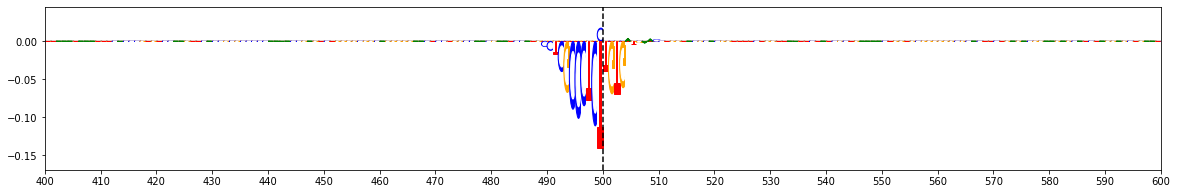


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 222

RSID: rs62054825 	 	 || 	 chr17 : 45852666 - 45852667 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 1.2500E-22 	 	 || 	 Coloc: True

Prominence P-Value: 2.6975E-02 	 || 	 Magnitude P-Value: 1.8843E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 7.9358E-03 	 || 	 ISM P-Value: 6.1373E-03 	 || 	 deltaSVM P-Value: 6.2802E-03

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Motif: GCTCCCGGAAGTGGAGTCATCCT



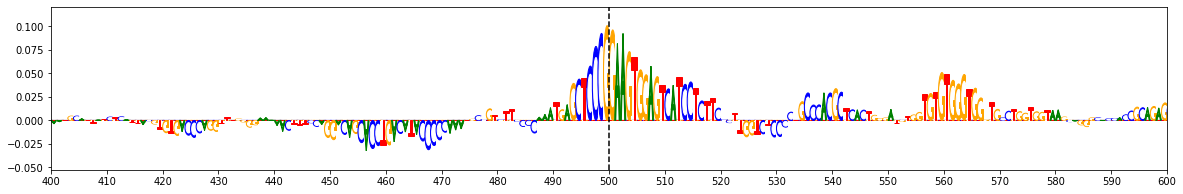


Non-Effect Allele: A 	 	 || 	 Inactive Motif: GCTCCCAGAAGTGGAGTCATCCT



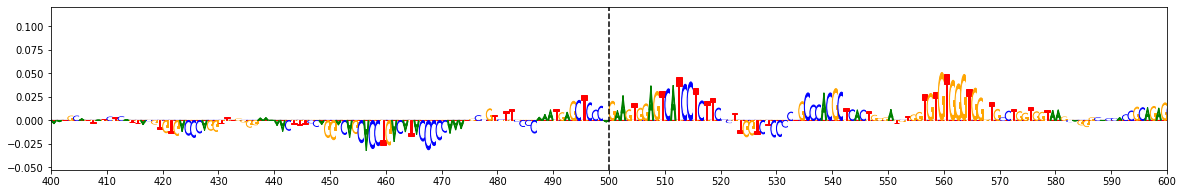


Difference Motif: GCTCCC(G/A)GAAGTGGAGTCATCCT



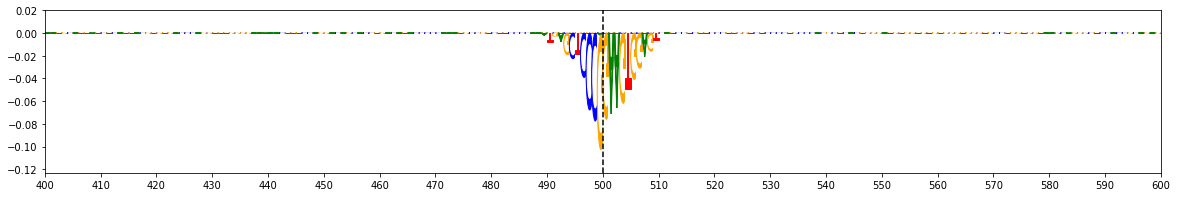


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 430

RSID: rs3772034 	 	 || 	 chr2 : 95324017 - 95324018 	 || 	 Locus: 85

GWAS: Nalls_23andMe 	 || 	 P-Value: 8.1200E-03 	 	 || 	 Coloc: False

Prominence P-Value: 2.8463E-02 	 || 	 Magnitude P-Value: 6.5455E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 4.2079E-02 	 || 	 ISM P-Value: 3.3105E-02 	 || 	 deltaSVM P-Value: 3.5185E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Motif: CAGAGGGAGCCCG



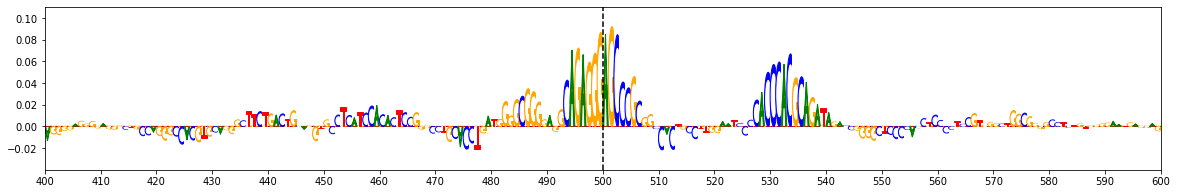


Non-Effect Allele: A 	 	 || 	 Inactive Motif: CAGAGGAAGCCCG



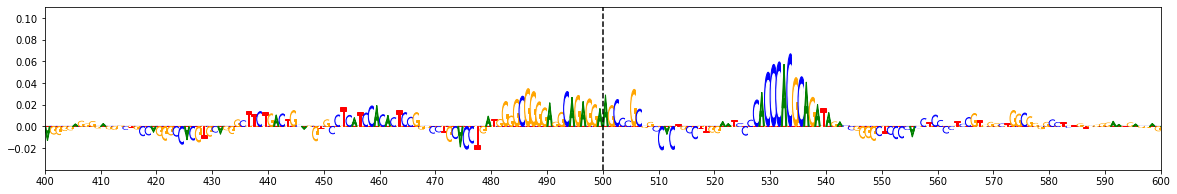


Difference Motif: CAGAGG(G/A)AGCCCG



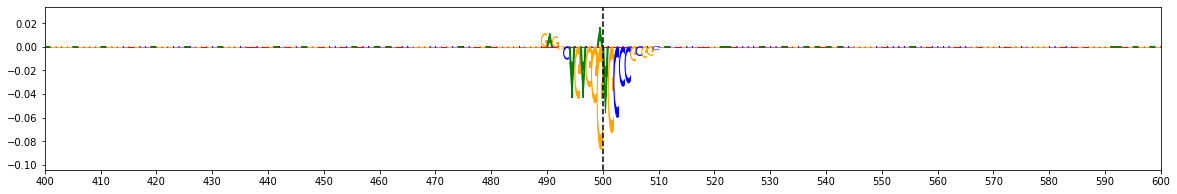


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 294

RSID: rs12150090 	 	 || 	 chr17 : 46038519 - 46038520 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 2.5100E-22 	 	 || 	 Coloc: True

Prominence P-Value: 3.5901E-02 	 || 	 Magnitude P-Value: 8.1322E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 6.5465E-03 	 || 	 ISM P-Value: 5.0865E-03 	 || 	 deltaSVM P-Value: 4.9807E-03

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Motif: CCAATCCCACA



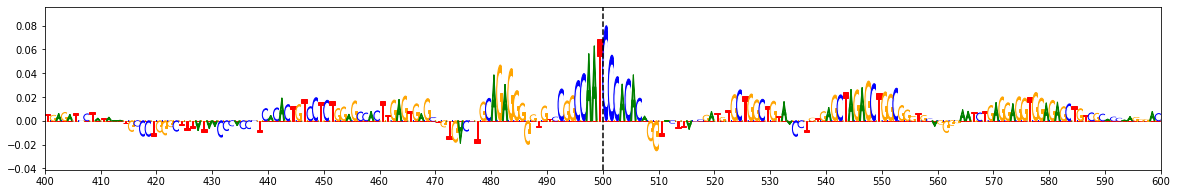


Non-Effect Allele: C 	 	 || 	 Inactive Motif: CCAACCCCACA



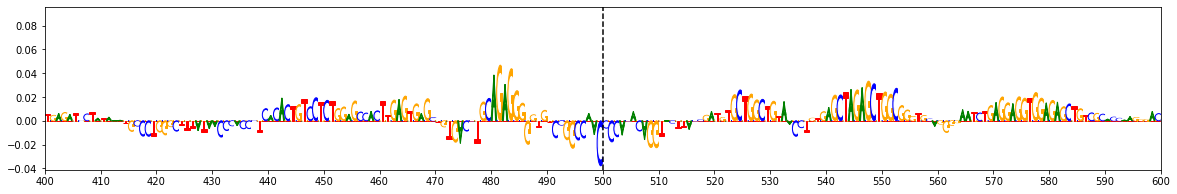


Difference Motif: CCAA(T/C)CCCACA



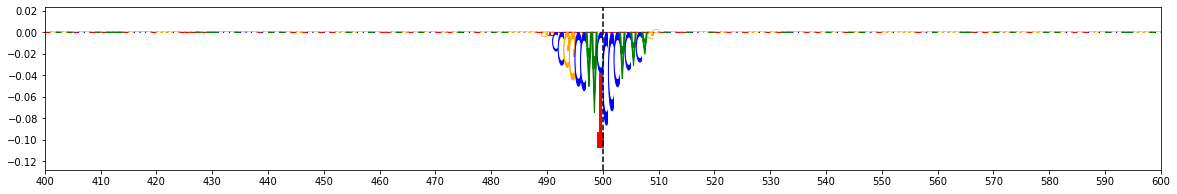


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 459

RSID: rs62171396 	 	 || 	 chr2 : 134719288 - 134719289 	 || 	 Locus: 78

GWAS: Nalls_23andMe 	 || 	 P-Value: 1.0399E-02 	 	 || 	 Coloc: False

Prominence P-Value: 4.8165E-02 	 || 	 Magnitude P-Value: 1.1835E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 2.7072E-02 	 || 	 ISM P-Value: 1.9955E-02 	 || 	 deltaSVM P-Value: 1.9626E-02

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Motif: CGGCTCTGGCAGAG



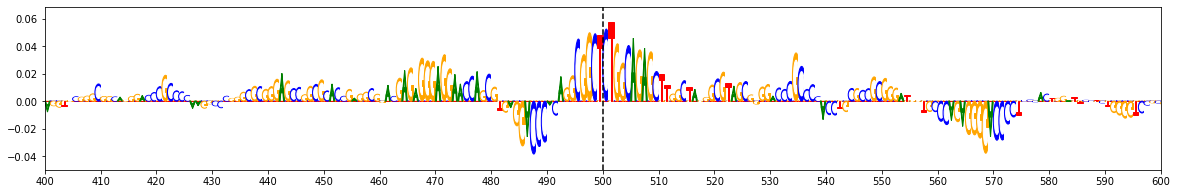


Non-Effect Allele: C 	 	 || 	 Inactive Motif: CGGCCCTGGCAGAG



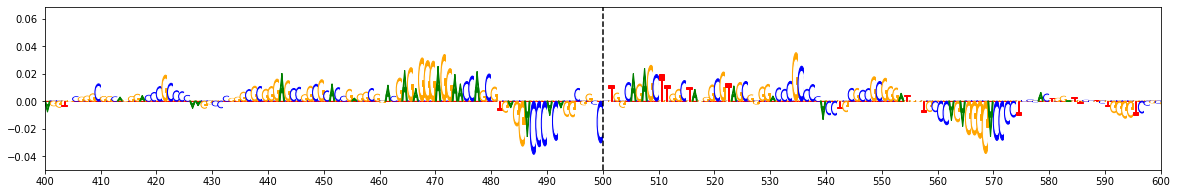


Difference Motif: CGGC(T/C)CTGGCAGAG



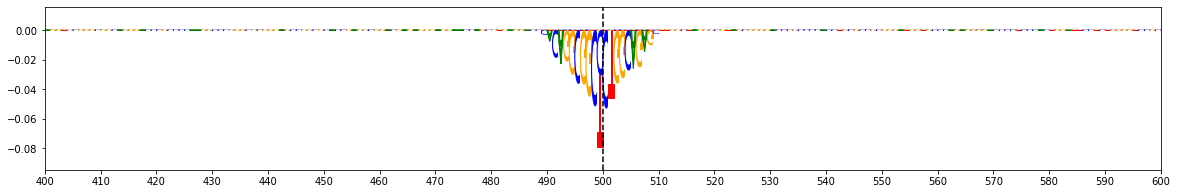


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in unique_sig_snps.loc[unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Motif:', row['diff_motif'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_real_noneffect_scores[index] - merged_real_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_real_effect_scores[index] - merged_real_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
unique_sig_snps['fc_track'] = fc_tracks
unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:2.3696250915527344
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 1

# Final Significant SNPs Table <a name='prep_final_table' />

In [29]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

final_sig_snps = unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_motif', 'diff_motif', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_motif,diff_motif,active_allele,fc_track,pval_track
59,chr11,86103987,86103988,rs1237999,A,G,A,G,+,16,Alzheimers_Jansen_2018,7.140000e-16,False,0.000182,0.000134,0.000139,0.000033,0.001455,2,TATGAGTCACCA,TAT(G/A)AGTCACCA,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
270,chr17,45959712,45959713,rs113793114,G,A,G,A,+,54,23andme_PD_hg38,2.580000e-22,True,0.016824,0.012727,0.012668,0.017058,0.005950,2,AGGAGGCGGA,AGGAGGC(G/A)GA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
583,chr4,89837895,89837896,rs2619363,NAN,NAN,G,"C,T",.,103,23andme_PD_hg38,1.430000e-08,True,0.004007,0.003465,0.002865,0.003372,0.006512,2,CCAATCAGCGCCTGCCAG,CCAATCAGC(G/C)CCTGCCAG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
41,chr11,60251676,60251677,rs636317,C,T,T,C,-,11,Alzheimers_Kunkle_2019,5.910000e-15,False,0.000006,0.000005,0.000004,0.000000,0.009785,2,TTTGCTGCCATCTGCTGGGAAATTGTG,TTTGCTGC(C/T)ATCTGCTGGGAAATTGTG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
240,chr17,45896863,45896864,rs62056782,T,C,C,T,-,54,23andme_PD_hg38,3.940000e-22,True,0.002924,0.002228,0.002227,0.001091,0.011174,2,CGCCCTCTTGTG,CGCCCTC(T/C)TGTG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
222,chr17,45852666,45852667,rs62054825,G,A,G,A,+,54,23andme_PD_hg38,1.250000e-22,True,0.007936,0.006137,0.006280,0.001884,0.026975,2,GCTCCCGGAAGTGGAGTCATCCT,GCTCCC(G/A)GAAGTGGAGTCATCCT,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
430,chr2,95324017,95324018,rs3772034,G,A,A,G,-,85,Nalls_23andMe,8.120010e-03,False,0.042079,0.033105,0.035185,0.006545,0.028463,2,CAGAGGGAGCCCG,CAGAGG(G/A)AGCCCG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
294,chr17,46038519,46038520,rs12150090,T,C,C,"G,T",-,54,23andme_PD_hg38,2.510000e-22,True,0.006547,0.005086,0.004981,0.008132,0.035901,2,CCAATCCCACA,CCAA(T/C)CCCACA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
459,chr2,134719288,134719289,rs62171396,T,C,C,T,-,78,Nalls_23andMe,1.039870e-02,False,0.027072,0.019955,0.019626,0.011835,0.048165,2,CGGCTCTGGCAGAG,CGGC(T/C)CTGGCAGAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
418,chr19,45326535,45326536,rs344791,C,G,C,G,-,71,Alzheimers_Jansen_2018,1.220000e-04,True,0.001873,0.001258,0.001291,0.054215,0.052132,1,CGCCTCC,C(G/C)CCTCC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
